<a href="https://colab.research.google.com/github/Sid00867/Atari-with-DQN---Deepmind-/blob/main/ataridqn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
from ale_py.vector_env import AtariVectorEnv
import numpy as np
import random
import gymnasium as gym # Import gymnasium as gym

# Create a vector environment with 4 parallel instances of Breakout

PARALLEL_ENVS = 4
minibatch_samples = 32
gamma = 0.99
optimizer_learning_rate = 0.00025

HELD_OUT_STATES_SIZE = 500
Q_EVAL_FREQUENCY = 50000  # Evaluate every 50,000 frames
TARGET_UPDATE_FREQUENCY = 8000

# Epsilon annealing parameters
epsilon_start = 1.0
epsilon_end = 0.01
epsilon_anneal_frames = 1_000_000  # Anneal over the first 1 million frames
total_training_frames = 5_000_000  # Train for a total of 10 million frames
replay_buffer_window = 150_000 # Increased for stability
LEARNING_STARTS = 50_000  # Replay memory of 1 million frames
steps_per_simulation = 64 # Simulate one step at a time to update epsilon more frequently

replay_buffer = []
T = total_training_frames # Use total_training_frames as the loop condition
frame_count = 0 # Initialize frame counter


envs = AtariVectorEnv(
    game="breakout",
    num_envs=PARALLEL_ENVS,

    frameskip=4,
    grayscale=True,
    stack_num=4,
    img_height=84,
    img_width=84,
    maxpool=True,
    reward_clipping=True,

    noop_max=30,
    use_fire_reset=True,
    episodic_life=True,
    life_loss_info=False,
    max_num_frames_per_episode=108000,
    repeat_action_probability=0.0,
    full_action_space=False,
    continuous=False,
    continuous_action_threshold=0.5,

    # no need to modify
    batch_size=0,
    autoreset_mode=gym.vector.AutoresetMode.NEXT_STEP, # Use gymnasium's AutoresetMode
    num_threads=0,
    thread_affinity_offset=-1,
)

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Check for GPU availability and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class AtariCNN(nn.Module):
    def __init__(self):
        super(AtariCNN, self).__init__()
        self.conv1 = nn.Conv2d(4, 16, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=4, stride=2)
        self.fc1 = nn.Linear(32 * 9 * 9, 256)  # Calculate input size based on output of conv2
        self.fc2 = nn.Linear(256, 4)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)  # Flatten the output of conv2
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = AtariCNN()
model.to(device) # Move the model to the selected device

target_model = AtariCNN()
target_model.to(device)

# Initialize target_model with the same weights as model
target_model.load_state_dict(model.state_dict())

# Set the target network to evaluation mode
target_model.eval()

Using device: cuda


AtariCNN(
  (conv1): Conv2d(4, 16, kernel_size=(8, 8), stride=(4, 4))
  (conv2): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2))
  (fc1): Linear(in_features=2592, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=4, bias=True)
)

In [3]:
def simulate_game(num_steps=1, epsilon=0.1):
    observations, info = envs.reset()
    resultdict = {}
    frames_processed = 0

    for step in range(num_steps):
        if np.random.rand() < epsilon:
            actions = envs.action_space.sample()
        else:
            # Create tensor and move it to the correct device
            obs_tensor = torch.tensor(observations, dtype=torch.float32).to(device)

            with torch.no_grad():
                q_values = model(obs_tensor)

            # Move tensor back to CPU before converting to numpy
            actions = torch.argmax(q_values, axis=1).cpu().numpy()

        prev_observations = observations.copy()
        observations, rewards, terminations, truncations, infos = envs.step(actions)

        frames_processed += 4 * PARALLEL_ENVS
        resultdict[step] = (prev_observations, observations, actions, rewards, terminations, truncations)

    return resultdict, frames_processed

In [4]:
def sample_minibatch( batch_size):
  if len(replay_buffer) < batch_size:
      # Not enough transitions to sample a full batch
      return replay_buffer
  minibatch = random.sample(replay_buffer, batch_size)
  return minibatch

In [5]:
def initialize_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

model.apply(initialize_weights)

print("Model weights initialized.")

Model weights initialized.


In [6]:
held_out_states = []
# Use a temporary environment instance to collect states
temp_env = AtariVectorEnv(game="breakout", num_envs=1, frameskip=4, grayscale=True, stack_num=4, img_height=84, img_width=84, maxpool=True)
obs, _ = temp_env.reset()
for _ in range(HELD_OUT_STATES_SIZE):
    action = temp_env.action_space.sample()
    next_obs, _, _, _, _ = temp_env.step(action)
    # Add the observation from the single environment
    held_out_states.append(torch.tensor(obs[0], dtype=torch.float32))
    obs = next_obs
temp_env.close()

# Stack states into a single tensor and move to the device for efficient evaluation
held_out_states_tensor = torch.stack(held_out_states).to(device)

# Lists to store data for plotting
eval_frames = []
avg_q_values = []

print(f"Collected {len(held_out_states)} states.")

Collected 500 states.


In [7]:
from tqdm import tqdm

latest_loss = 0.0
latest_avg_q = 0.0

progress_bar = tqdm(total=total_training_frames, unit='frames', desc="Training")

Training:   0%|          | 0/5000000 [00:00<?, ?frames/s]

In [8]:
optimizer = torch.optim.RMSprop(model.parameters(), lr=optimizer_learning_rate, alpha=0.95, eps=0.01)

while frame_count < total_training_frames:
    if frame_count < epsilon_anneal_frames:
        epsilon = epsilon_start - (frame_count / epsilon_anneal_frames) * (epsilon_start - epsilon_end)
    else:
        epsilon = epsilon_end

    resultdict, frames_this_sim = simulate_game(num_steps=steps_per_simulation, epsilon=epsilon)

    transition = []
    for step in resultdict:
        prev_observations, observations, actions, rewards, terminations, truncations = resultdict[step]
        for i in range(PARALLEL_ENVS):
            transition.append((prev_observations[i],
                               actions[i],
                               rewards[i],
                               observations[i],
                               terminations[i],
                               truncations[i]))
    replay_buffer += transition

    if len(replay_buffer) > replay_buffer_window:
        replay_buffer = replay_buffer[-replay_buffer_window:]

    progress_bar.update(frames_this_sim)
    frame_count += frames_this_sim

    if frame_count > 0 and (len(eval_frames) == 0 or frame_count - eval_frames[-1] >= Q_EVAL_FREQUENCY):
      # Set the model to evaluation mode
      model.eval()
      with torch.no_grad():
          q_preds = model(held_out_states_tensor)
          max_q, _ = torch.max(q_preds, dim=1)
          avg_max_q = max_q.mean().item()
          latest_avg_q = avg_max_q

      eval_frames.append(frame_count)
      avg_q_values.append(avg_max_q)
      # print(f"Frame: {frame_count} | Average Max-Q: {avg_max_q:.2f}")

      # Set the model back to training mode
      model.train()



    if len(replay_buffer) >= minibatch_samples and frame_count > LEARNING_STARTS:
        minibatch = sample_minibatch(minibatch_samples)

        # --- 1. Unpack the minibatch into separate tensors in one go ---
        prev_obs_batch = torch.stack([torch.tensor(m[0]) for m in minibatch]).float().to(device)
        action_batch = torch.tensor([m[1] for m in minibatch]).long().to(device)
        reward_batch = torch.tensor([m[2] for m in minibatch]).float().to(device)
        obs_batch = torch.stack([torch.tensor(m[3]) for m in minibatch]).float().to(device)
        # Combine termination and truncation into a single 'done' flag
        done_batch = torch.tensor([m[4] or m[5] for m in minibatch]).bool().to(device)

        with torch.no_grad():
            next_q_values_full = target_model(obs_batch)

        # --- 3. Find the max Q-value for each of those next states ---
        next_max_q_values, _ = torch.max(next_q_values_full, dim=1)

        target_q_values = reward_batch + (~done_batch) * gamma * next_max_q_values

        # --- 5. Get the predicted Q-values for the actions that were actually taken ---
        predicted_q_values_full = model(prev_obs_batch)
        predicted_q_for_actions = predicted_q_values_full.gather(1, action_batch.unsqueeze(1)).squeeze(1)

        # --- 6. Calculate loss and update the model ---
        loss = F.mse_loss(predicted_q_for_actions, target_q_values)
        latest_loss = loss.item()

        optimizer.zero_grad()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        if frame_count % TARGET_UPDATE_FREQUENCY == 0:
          target_model.load_state_dict(model.state_dict())

        progress_bar.set_postfix({
            "loss": f"{latest_loss:.4f}",
            "avg_q": f"{latest_avg_q:.2f}",
            "epsilon": f"{epsilon:.3f}"
        })

progress_bar.close()
envs.close()
print("Training finished.")

Training:   1%|          | 50176/5000000 [00:28<28:20, 2910.87frames/s]/tmp/ipython-input-224112536.py:56: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  done_batch = torch.tensor([m[4] or m[5] for m in minibatch]).bool().to(device)
Training: 5000192frames [33:18, 2502.11frames/s, loss=34.8956, avg_q=71.41, epsilon=0.010]

Training finished.


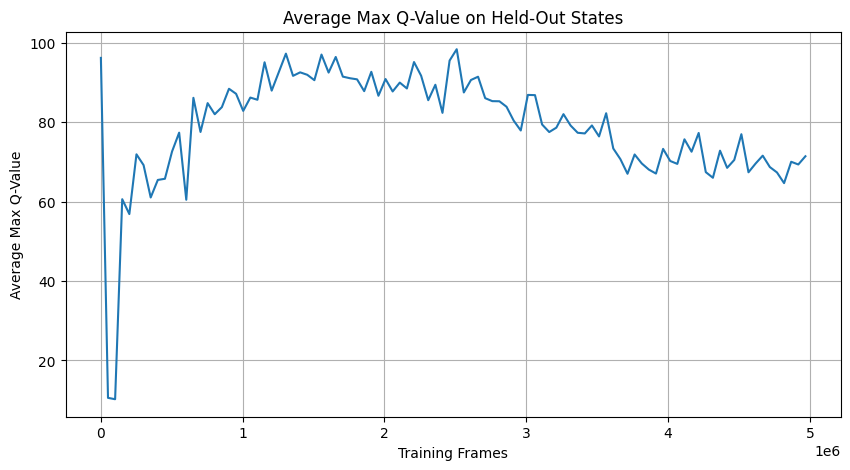

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(eval_frames, avg_q_values)
plt.title("Average Max Q-Value on Held-Out States")
plt.xlabel("Training Frames")
plt.ylabel("Average Max Q-Value")
plt.grid(True)
plt.show()

In [24]:
def evaluate_policy(model, num_games=10, device="cuda"):
    eval_env = AtariVectorEnv(
      game="breakout",
      num_envs=1,

      frameskip=4,
      grayscale=True,
      stack_num=4,
      img_height=84,
      img_width=84,
      maxpool=True,
      reward_clipping=True, # Note: a score of 1.0 means one brick was hit

      noop_max=30,
      use_fire_reset=True,
      episodic_life=True,
      life_loss_info=False,
      max_num_frames_per_episode=108000,
      repeat_action_probability=0.0,
      full_action_space=False,
      continuous=False,
      continuous_action_threshold=0.5,

      batch_size=0,
      autoreset_mode=gym.vector.AutoresetMode.NEXT_STEP,
    )

    episode_scores = []
    model.eval()

    print(f"Running evaluation for {num_games} games...")

    for i in range(num_games):
        obs, info = eval_env.reset()
        done = False
        total_reward = 0.0
        current_lives = info['lives'][0]
        while not done:

            obs_tensor = torch.tensor(obs, dtype=torch.float32).to(device)

            with torch.no_grad():
                q_values = model(obs_tensor)

            action = torch.argmax(q_values, dim=1).cpu().numpy()
            obs, reward, terminated, truncated, infos = eval_env.step(action)

            total_reward += reward[0]
            done = terminated[0] or truncated[0]

            new_lives = infos['lives'][0]
            if new_lives < current_lives:
                # A life was lost. We must fire, AND we must update the state.
                # ✅ --- THIS IS THE FIX --- ✅
                # Capture the new state after firing the ball.
                obs, _, _, _, infos = eval_env.step(np.array([1], dtype=np.int32))
                # It's possible the game ends right after this step, so update 'done'.
                done = terminated[0] or truncated[0]

            current_lives = new_lives

        episode_scores.append(total_reward)
        print(f"  Game {i + 1}/{num_games} | Score: {total_reward}")

    eval_env.close()

    avg_score = np.mean(episode_scores)
    std_score = np.std(episode_scores)

    return avg_score, std_score



avg_score, std_score = evaluate_policy(model, num_games=50, device=device)
print("\n" + "="*30)
print(f"Evaluation Complete!")
print(f"Average Score: {avg_score:.2f} +/- {std_score:.2f}")
print("="*30)

Running evaluation for 50 games...
  Game 1/50 | Score: 0.0
  Game 2/50 | Score: 0.0
  Game 3/50 | Score: 0.0
  Game 4/50 | Score: 0.0
  Game 5/50 | Score: 0.0
  Game 6/50 | Score: 0.0
  Game 7/50 | Score: 0.0
  Game 8/50 | Score: 0.0
  Game 9/50 | Score: 0.0
  Game 10/50 | Score: 0.0
  Game 11/50 | Score: 0.0
  Game 12/50 | Score: 0.0
  Game 13/50 | Score: 0.0
  Game 14/50 | Score: 0.0
  Game 15/50 | Score: 0.0
  Game 16/50 | Score: 0.0
  Game 17/50 | Score: 0.0
  Game 18/50 | Score: 0.0
  Game 19/50 | Score: 0.0
  Game 20/50 | Score: 0.0
  Game 21/50 | Score: 0.0
  Game 22/50 | Score: 0.0
  Game 23/50 | Score: 0.0
  Game 24/50 | Score: 0.0
  Game 25/50 | Score: 0.0
  Game 26/50 | Score: 0.0
  Game 27/50 | Score: 0.0
  Game 28/50 | Score: 0.0
  Game 29/50 | Score: 0.0
  Game 30/50 | Score: 0.0
  Game 31/50 | Score: 0.0
  Game 32/50 | Score: 0.0
  Game 33/50 | Score: 0.0
  Game 34/50 | Score: 0.0
  Game 35/50 | Score: 0.0
  Game 36/50 | Score: 0.0
  Game 37/50 | Score: 0.0
  Game 38/50

In [16]:
DEFAULT_PATH = '/content/drive/MyDrive/model_weights.pth'

torch.save(model.state_dict(), DEFAULT_PATH)
print(f"Model saved to {DEFAULT_PATH}")

Model saved to /content/drive/MyDrive/model_weights.pth
